# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [9]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [10]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [11]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [12]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\tangu\\Documents\\UNINE\\BA4\\Application de méthodes numériques\\Projet\\network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [13]:
## define SPARQL enpoint
endpoint = "https://ag1mftakvrjmpfvp.allegrograph.cloud/repositories/judges"

In [14]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/TanguyGodat/Judges/blob/main/graphs/wikidata_imported_data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [15]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


38046
[['http://www.wikidata.org/entity/Q101109361',
  'Paweł Juszczyszyn',
  '1972',
  'education',
  'http://www.wikidata.org/entity/Q1752712',
  'Nicolaus Copernicus University in Toruń',
  '2',
  'open-access publisher | university'],
 ['http://www.wikidata.org/entity/Q101109361',
  'Paweł Juszczyszyn',
  '1972',
  'membership',
  'http://www.wikidata.org/entity/Q9346291',
  'Polish Judges Association "Iustitia"',
  '1',
  'association'],
 ['http://www.wikidata.org/entity/Q101131',
  'Michael Eichberger',
  '1953',
  'education',
  'http://www.wikidata.org/entity/Q317070',
  'University of Mannheim',
  '2',
  'organization | public university']]


## Inspect the data


In [16]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  38046


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,membership,http://www.wikidata.org/entity/Q265058,Hungarian Academy of Sciences,4,public body | national academy | organization ...
11,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,employment,http://www.wikidata.org/entity/Q1187444,University of Pécs,1,university
12,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,education,http://www.wikidata.org/entity/Q1115639,Franz Joseph University,1,university


### Distribution of relationships in relation to birthYears of organisations members

In [26]:
l_50 = list(range(1800, 2001, 25))
print(l_50)

[1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000]


In [28]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000]

In [ ]:
### 30 years periods, but some customisations
# lc = [1800, 1826, 1852, 1878, 1904, 1930, 1956, 1982]

In [29]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [30]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,education,http://www.wikidata.org/entity/Q180865,University of Toronto,3,public research university | collegiate univer...,1925-1949
5,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,employment,http://www.wikidata.org/entity/Q675848,University of Zagreb,2,open-access publisher | public university,1925-1949
10,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,membership,http://www.wikidata.org/entity/Q265058,Hungarian Academy of Sciences,4,public body | national academy | organization ...,1850-1874


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [ ]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

38046


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
0,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,1912,membership,http://www.wikidata.org/entity/Q119239,National Socialist Women's League,1,women's wing,1900-1924
1,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,education,http://www.wikidata.org/entity/Q180865,University of Toronto,3,public research university | collegiate univer...,1925-1949


In [33]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1800-1824     1646
1825-1849     2209
1850-1874     3116
1875-1899     4219
1900-1924     6263
1925-1949    10807
1950-1974     9205
1975-1999      540
dtype: int64


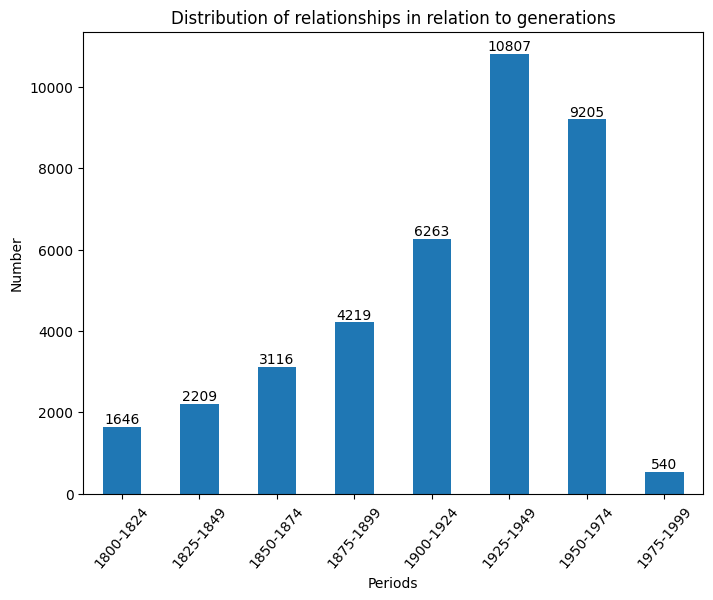

In [34]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [35]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     28443
employment     5959
membership     3644
dtype: int64


In [36]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1800-1824   education  1191
1   1800-1824  employment   150
2   1800-1824  membership   305
3   1825-1849   education  1497
4   1825-1849  employment   252
5   1825-1849  membership   460
6   1850-1874   education  2338
7   1850-1874  employment   312
8   1850-1874  membership   466
9   1875-1899   education  2986
10  1875-1899  employment   598
11  1875-1899  membership   635
12  1900-1924   education  4736
13  1900-1924  employment   934
14  1900-1924  membership   593
15  1925-1949   education  8201
16  1925-1949  employment  1848
17  1925-1949  membership   758
18  1950-1974   education  7084
19  1950-1974  employment  1724
20  1950-1974  membership   397
21  1975-1999   education   383
22  1975-1999  employment   129
23  1975-1999  membership    28


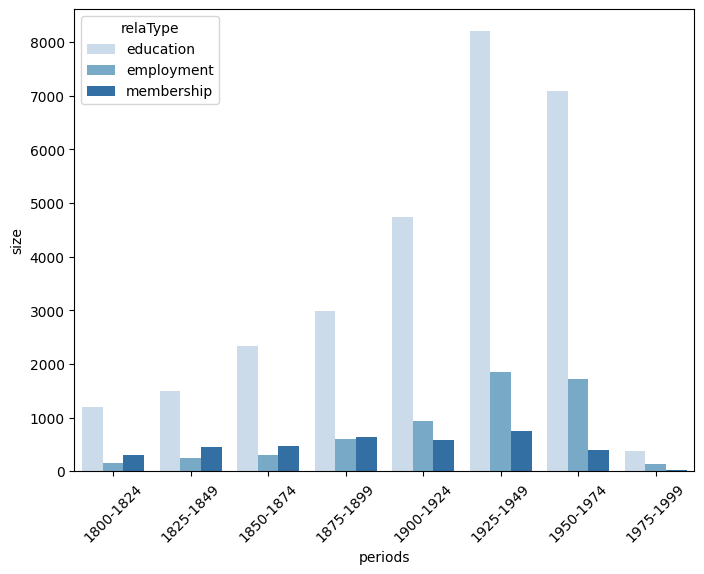

In [37]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [38]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


38046
[["women's wing"],
 ['collegiate university',
  'public research university',
  'university in ontario'],
 ['musical group']]


In [39]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,education,http://www.wikidata.org/entity/Q180865,University of Toronto,3,collegiate university | public research univer...,1925-1949,"[collegiate university, public research univer..."
5,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,employment,http://www.wikidata.org/entity/Q675848,University of Zagreb,2,open-access publisher | public university,1925-1949,"[open-access publisher, public university]"
10,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,membership,http://www.wikidata.org/entity/Q265058,Hungarian Academy of Sciences,4,academy of sciences | national academy | organ...,1850-1874,"[academy of sciences, national academy, organi..."


#### Organisations' types distribution

In [40]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
law school                                                                          4047
university                                                                          1357
open-access publisher | public university                                            893
public university                                                                    854
high school                                                                          826
public educational institution of the united states | public research university     803
graduate school | law school | publishing company                                    667
private not-for-profit educational institution | university                          631
federal courts (germany) | supreme court                                             600
academic publisher | law school                                                      504
dtype: int64


#### Save dataframe to CSV

In [41]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [42]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,law school,4047,1
1,university,1357,1
2,open-access publisher | public university,893,2
3,public university,854,1
4,high school,826,1
5,public educational institution of the united s...,803,2
6,graduate school | law school | publishing company,667,3
7,private not-for-profit educational institution...,631,2
8,federal courts (germany) | supreme court,600,2
9,academic publisher | law school,504,2


In [ ]:
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [47]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,1912,membership,http://www.wikidata.org/entity/Q119239,National Socialist Women's League,1,women's wing,1900-1924,[women's wing]


In [48]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'observato' in x:
        val = 'astronomical observatory'  
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'      
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company or gov. agency' # could also be 'company'
    elif 'government' in x :
        val = 'company or gov. agency' # could also be 'government agency'         
    elif 'publish' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'     
    elif 'journal' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'
    elif 'periodical' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [49]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,membership,http://www.wikidata.org/entity/Q115095,Institut de Droit International,4,learned society | national academy | non-gover...,1925-1949,"[learned society, national academy, non-govern...",learned society
8,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,employment,http://www.wikidata.org/entity/Q182016,United Nations Environment Programme,3,environmental organization | nonprofit organiz...,1925-1949,"[environmental organization, nonprofit organiz...",scientific organisation
9,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,membership,http://www.wikidata.org/entity/Q54129,International Labour Organization,2,international organization | specialized agenc...,1925-1949,"[international organization, specialized agenc...",not classified organisation


In [50]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
12,university,12398
3,educational institution,10970
8,public university,5949
6,not classified organisation,4149
7,private university,2858
5,learned society,644
2,company or gov. agency,405
0,academy of sciences,308
11,scientific organisation,236
10,research organisation,61


In [52]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
1780,private not-for-profit educational institution...,university,631,2
959,federal courts (germany) | supreme court,not classified organisation,600,2
52,academic publisher | law school,educational institution,504,2


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [53]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
288,http://www.wikidata.org/entity/Q103092,Hein Kötz,1935,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1925-1949,"[academy, charitable organization, organization]",research organisation
1610,http://www.wikidata.org/entity/Q109532,Angelika Nussberger,1963,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1950-1974,"[academy, charitable organization, organization]",research organisation


# Create graphs

In [54]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     28443
employment     5959
membership     3644
dtype: int64


### Prepare the dataframe

In [55]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

38046


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [56]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
3617,http://www.wikidata.org/entity/Q49122,Harvard Law School,graduate school | law school | publishing company,educational institution,667
5092,http://www.wikidata.org/entity/Q687323,Federal Court of Justice of Germany,federal courts (germany) | supreme court,not classified organisation,599
2236,http://www.wikidata.org/entity/Q230492,University of Michigan,public educational institution of the united s...,university,281
6487,http://www.wikidata.org/entity/Q911830,University of Michigan Law School,law school,educational institution,271
432,http://www.wikidata.org/entity/Q1143289,Yale Law School,academic publisher | law school,educational institution,266
988,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,private university,246
451,http://www.wikidata.org/entity/Q1149089,Columbia Law School,law school,educational institution,246
1557,http://www.wikidata.org/entity/Q165980,University of Vienna,university,university,229
6117,http://www.wikidata.org/entity/Q7896545,University of Virginia School of Law,faculty | law school,university,221
640,http://www.wikidata.org/entity/Q12047389,"Faculty of Law, Charles University in Prague",faculty | faculty of law | research institute,university,217


In [59]:
### Save list of organisations as CSV
csv_file='data/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [64]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods'], observed=True).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
2082,http://www.wikidata.org/entity/Q1458695,National University of Kharkiv,university,1800-1824,2
4323,http://www.wikidata.org/entity/Q2422271,Instituto Nacional General José Miguel Carrera,educational institution,1800-1824,5
7661,http://www.wikidata.org/entity/Q5430237,Fairfield Academy,educational institution,1800-1824,1
4331,http://www.wikidata.org/entity/Q2428745,Fort William College,educational institution,1800-1824,1
4342,http://www.wikidata.org/entity/Q245247,King's College London,university,1800-1824,6


In [65]:
df_orgPeriod[df_orgPeriod.labelOrg=='AMOLF']

,uriOrg,labelOrg,orgMainType,periods,period_members_number


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [67]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods'], observed=True).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
10257,http://www.wikidata.org/entity/Q687323,Federal Court of Justice of Germany,not classified organisation,employment,1925-1949,208
7592,http://www.wikidata.org/entity/Q49122,Harvard Law School,educational institution,education,1925-1949,184
10256,http://www.wikidata.org/entity/Q687323,Federal Court of Justice of Germany,not classified organisation,employment,1900-1924,173
10258,http://www.wikidata.org/entity/Q687323,Federal Court of Justice of Germany,not classified organisation,employment,1950-1974,154
7591,http://www.wikidata.org/entity/Q49122,Harvard Law School,educational institution,education,1900-1924,153


In [69]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='data/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

312


C:\Users\tangu\AppData\Local\Temp\ipykernel_23576\3267515496.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\


,periods,relaType,orgMainType,period_members_number
0,1800-1824,education,academy of sciences,0
1,1800-1824,education,astronomical observatory,0
2,1800-1824,education,company or gov. agency,0
3,1800-1824,education,educational institution,409
4,1800-1824,education,institute of technology,1
5,1800-1824,education,learned society,0
6,1800-1824,education,not classified organisation,18
7,1800-1824,education,private university,180
8,1800-1824,education,public university,174
9,1800-1824,education,research facility,0


In [70]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

33


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [71]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [72]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [73]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy of sciences,0,0,308,308
astronomical observatory,13,0,0,13
company or gov. agency,2,325,78,405
educational institution,10576,337,57,10970
institute of technology,21,25,0,46
learned society,9,9,604,622
not classified organisation,161,1812,2176,4149
private university,2459,399,0,2858
public university,4461,1487,1,5949


In [74]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy of sciences,0,0,308
astronomical observatory,13,0,0
company or gov. agency,2,325,78
educational institution,10576,337,57
institute of technology,21,25,0
learned society,9,9,604
not classified organisation,161,1812,2176
private university,2459,399,0
public university,4461,1487,1


In [75]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 29330.06 , dof : 24
p-value : 0.0
phi2 = inertie (variance totale) : 0.7709104125292108
Cramer:  0.6208503895984969


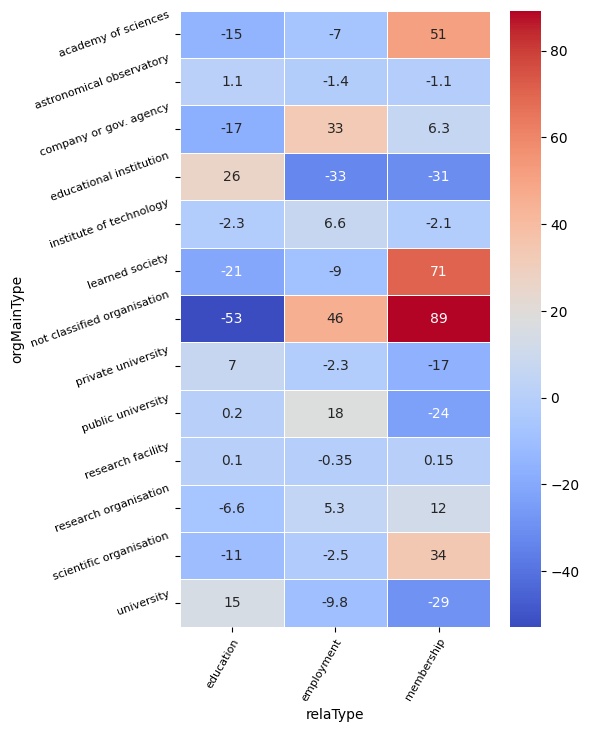

In [76]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [77]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [78]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1800-1824,1825-1849,1850-1874,1875-1899,1900-1924,1925-1949,1950-1974,1975-1999,Total
orgMainType,,,,,,,,,
academy of sciences,34,37,46,39,47,87,18,0,308
astronomical observatory,0,1,2,1,2,5,2,0,13
company or gov. agency,15,26,28,48,64,115,95,14,405
educational institution,425,577,883,1159,2014,3148,2632,124,10962
institute of technology,4,3,7,2,8,7,14,1,46
learned society,57,79,87,98,87,153,60,1,622
not classified organisation,221,367,313,597,734,916,900,90,4138
private university,194,154,257,324,456,823,613,35,2856
public university,210,259,401,606,869,1782,1725,91,5943


In [79]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [80]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 895.45 , dof : 84
p-value : 5.80765620131168e-136
phi2 = inertie (variance totale) : 0.023561392419313938
Cramer:  0.058016490782872535


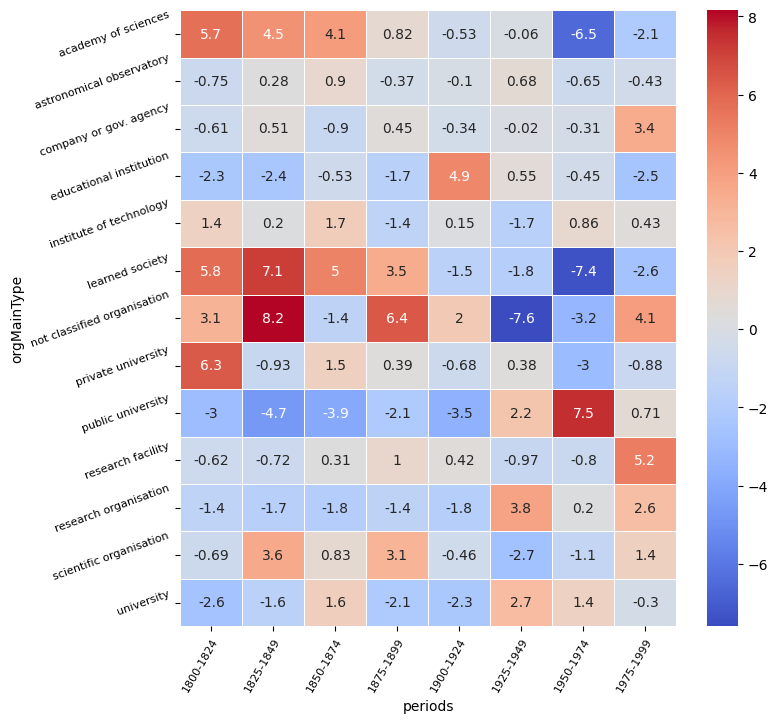

In [81]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [82]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1800-1824,1825-1849,1850-1874,1875-1899,1900-1924,1925-1949,1950-1974,1975-1999,Total
relaType,,,,,,,,,
education,1191,1497,2338,2986,4736,8201,7084,383,28416
employment,150,252,312,598,934,1848,1724,129,5947
membership,305,460,466,635,593,758,397,28,3642
Total,1646,2209,3116,4219,6263,10807,9205,540,38005


In [83]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [84]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 1275.99 , dof : 14
p-value : 7.902502341545173e-264
phi2 = inertie (variance totale) : 0.03357429047836302
Cramer:  0.12956521616229222


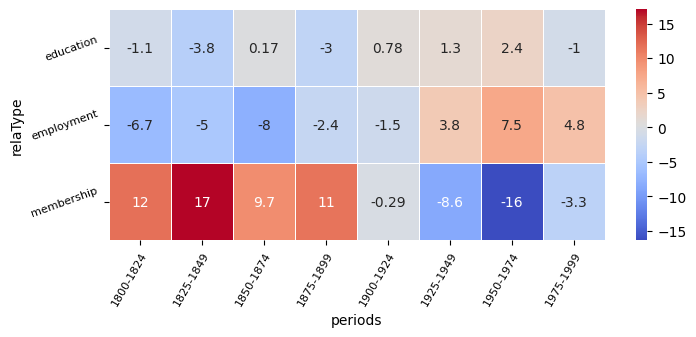

In [85]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [86]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [87]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



KeyError: "['periods_relaType'] not in index"

In [88]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [89]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 1275.99 , dof : 14
p-value : 7.902502341545173e-264
phi2 = inertie (variance totale) : 0.03357429047836302
Cramer:  0.12956521616229222


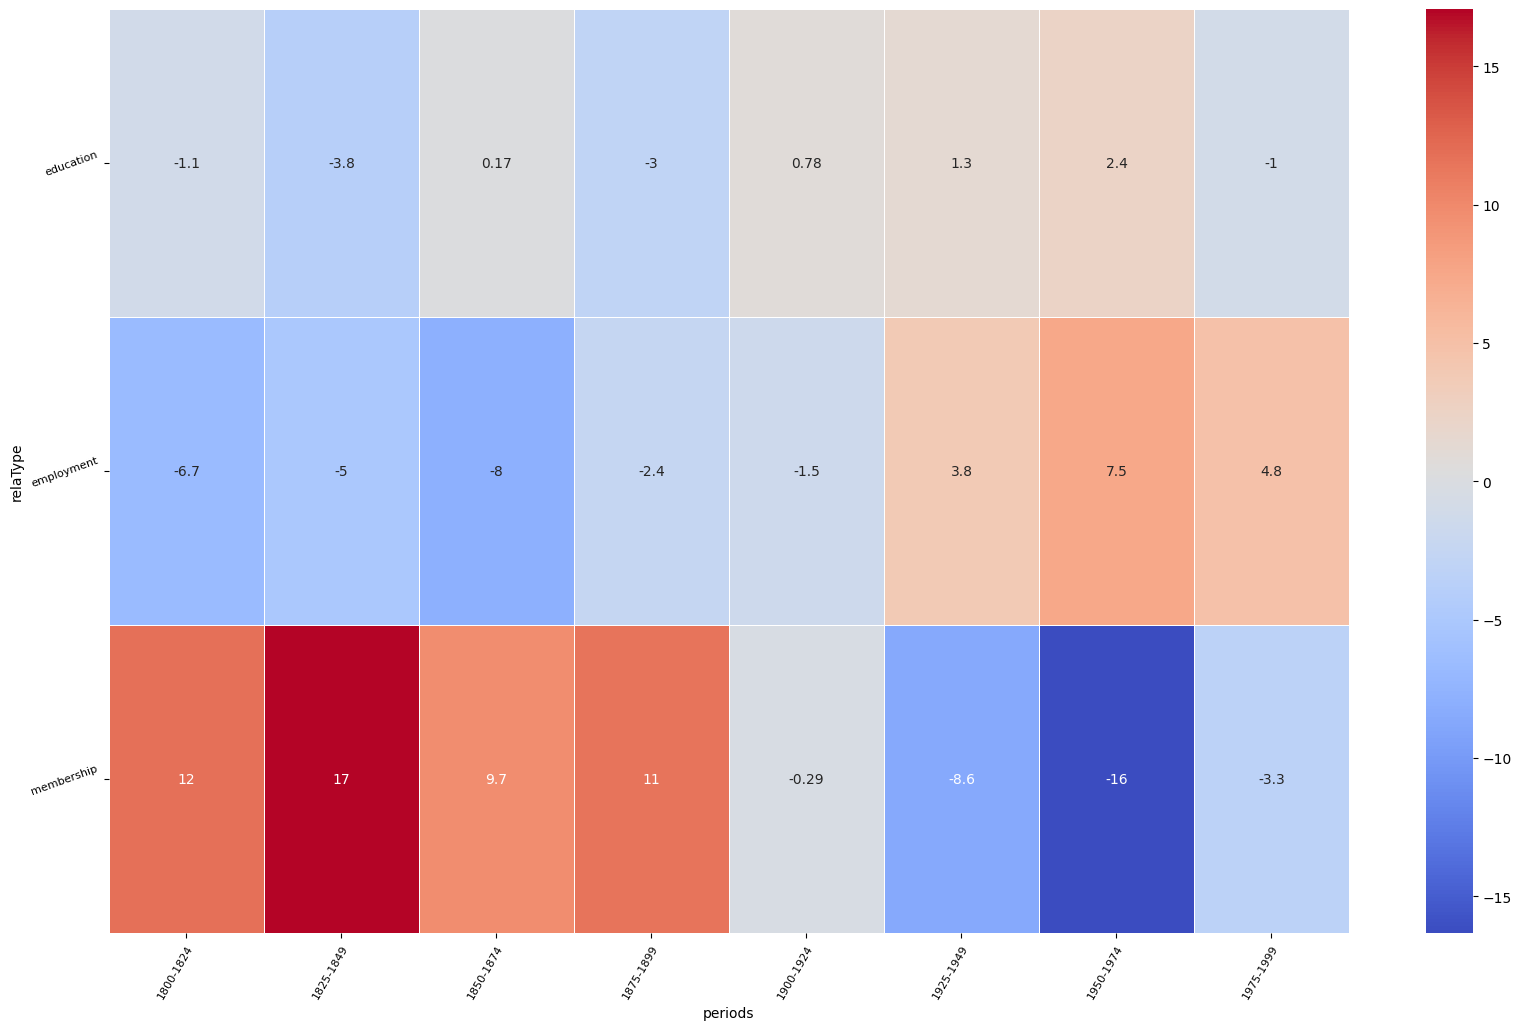

In [90]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [91]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


107204


In [92]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [93]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

33697
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
349,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q40025,Friedrich-Alexander-Universität Erlangen-Nürnberg,comprehensive university | organization | publ...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,comprehensive university | public research uni...,public university,employment
354,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q151510,Heidelberg University,comprehensive university | open-access publish...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q40025,Friedrich-Alexander-Universität Erlangen-Nürnberg,comprehensive university | organization | publ...,public university,employment
355,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q151510,Heidelberg University,comprehensive university | open-access publish...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,comprehensive university | public research uni...,public university,employment
364,http://www.wikidata.org/entity/Q1016882,Burr Harrison,1904,http://www.wikidata.org/entity/Q213439,University of Virginia,public educational institution of the united s...,university,education,1900-1924,http://www.wikidata.org/entity/Q846101,Georgetown University Law Center,law school,educational institution,education


In [94]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     28443
employment     5959
membership     3644
dtype: int64


In [95]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,education,education,15377
3,employment,education,3688
1,education,employment,3228
4,employment,employment,3133
6,membership,education,2507
2,education,membership,1758
8,membership,membership,1521
7,membership,employment,1326
5,employment,membership,1159


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [96]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [97]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [98]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [99]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
349,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q40025,Friedrich-Alexander-Universität Erlangen-Nürnberg,comprehensive university | organization | publ...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,comprehensive university | public research uni...,public university,employment
354,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q151510,Heidelberg University,comprehensive university | open-access publish...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q40025,Friedrich-Alexander-Universität Erlangen-Nürnberg,comprehensive university | organization | publ...,public university,employment
355,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q151510,Heidelberg University,comprehensive university | open-access publish...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,comprehensive university | public research uni...,public university,employment
364,http://www.wikidata.org/entity/Q1016882,Burr Harrison,1904,http://www.wikidata.org/entity/Q213439,University of Virginia,public educational institution of the united s...,university,education,1900-1924,http://www.wikidata.org/entity/Q846101,Georgetown University Law Center,law school,educational institution,education
366,http://www.wikidata.org/entity/Q1016882,Burr Harrison,1904,http://www.wikidata.org/entity/Q213439,University of Virginia,public educational institution of the united s...,university,education,1900-1924,http://www.wikidata.org/entity/Q785357,Virginia Military Institute,military academy | military school | public ed...,educational institution,education
367,http://www.wikidata.org/entity/Q1016882,Burr Harrison,1904,http://www.wikidata.org/entity/Q213439,University of Virginia,public educational institution of the united s...,university,education,1900-1924,http://www.wikidata.org/entity/Q8032350,Woodberry Forest School,school,educational institution,education
373,http://www.wikidata.org/entity/Q1016882,Burr Harrison,1904,http://www.wikidata.org/entity/Q1797609,Hampden–Sydney College,liberal arts college in the united states | pr...,university,education,1900-1924,http://www.wikidata.org/entity/Q213439,University of Virginia,public educational institution of the united s...,university,education


In [100]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,education,education,15377
1,education,employment,6916
2,education,membership,4265
3,employment,employment,3133
4,employment,membership,2485
5,membership,membership,1521


In [101]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [102]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,relaType_concat
349,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q40025,Friedrich-Alexander-Universität Erlangen-Nürnberg,comprehensive university | organization | publ...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,comprehensive university | public research uni...,public university,employment,employment_employment
354,http://www.wikidata.org/entity/Q101408,Klaus Vogel,1930,http://www.wikidata.org/entity/Q151510,Heidelberg University,comprehensive university | open-access publish...,public university,employment,1925-1949,http://www.wikidata.org/entity/Q40025,Friedrich-Alexander-Universität Erlangen-Nürnberg,comprehensive university | organization | publ...,public university,employment,employment_employment


In [105]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False, observed=True).agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [106]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


29650


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
8415,1900-1924,education_education,http://www.wikidata.org/entity/Q230492,University of Michigan,university,http://www.wikidata.org/entity/Q911830,University of Michigan Law School,educational institution,"John Earl Henderson|George W. Crockett, Jr.|Wi...",http://www.wikidata.org/entity/Q13219426|http:...,38
2538,1850-1874,education_education,http://www.wikidata.org/entity/Q230492,University of Michigan,university,http://www.wikidata.org/entity/Q911830,University of Michigan Law School,educational institution,Ernest W. Gibson|Ferdinand Brucker|George Suth...,http://www.wikidata.org/entity/Q1356333|http:/...,35
13854,1925-1949,education_education,http://www.wikidata.org/entity/Q230492,University of Michigan,university,http://www.wikidata.org/entity/Q911830,University of Michigan Law School,educational institution,"Harold Michael Fong|Blair Moody, Jr.|Theodore ...",http://www.wikidata.org/entity/Q15452185|http:...,34
4807,1875-1899,education_education,http://www.wikidata.org/entity/Q230492,University of Michigan,university,http://www.wikidata.org/entity/Q911830,University of Michigan Law School,educational institution,Guy T. Helvering|J. Stanley Webster|Jackson B....,http://www.wikidata.org/entity/Q1234807|http:/...,28
18237,1925-1949,education_membership,http://www.wikidata.org/entity/Q160302,University of Edinburgh,public university,http://www.wikidata.org/entity/Q5428890,Faculty of Advocates,not classified organisation,"Donald Mackay, Baron Mackay of Drumadoon|Iain ...",http://www.wikidata.org/entity/Q1240108|http:/...,22


### Explore contingency table of relationship pairs to periods

In [108]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1800-1824,1825-1849,1850-1874,1875-1899,1900-1924,1925-1949,1950-1974,1975-1999,Total
relaType_concat,,,,,,,,,
education_education,275,378,687,1254,2247,4218,3673,217,12949
education_employment,100,256,285,491,852,2171,2080,197,6432
education_membership,182,312,453,478,541,1063,602,72,3703
employment_employment,32,147,111,282,312,915,1075,95,2969
employment_membership,56,147,191,305,348,766,360,49,2222
membership_membership,53,171,260,238,166,313,153,21,1375
Total,698,1411,1987,3048,4466,9446,7943,651,29650


In [109]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [110]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 2112.04 , dof : 35
p-value : 0.0
phi2 = inertie (variance totale) : 0.07123238267391063
Cramer:  0.11935860477896902


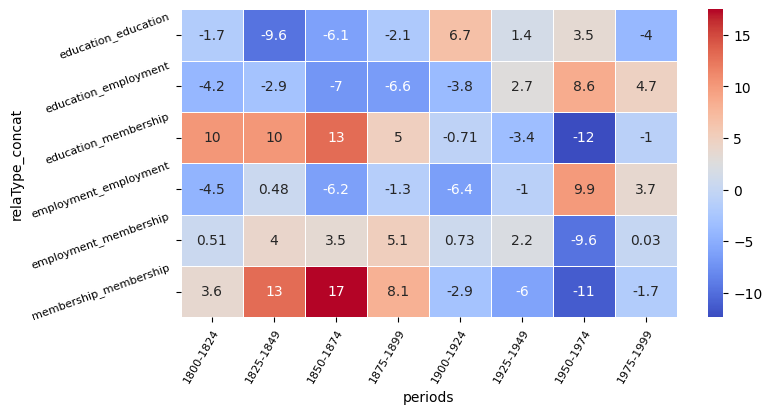

In [111]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [112]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['academy of sciences',
 'astronomical observatory',
 'company or gov. agency',
 'educational institution',
 'institute of technology',
 'learned society',
 'not classified organisation',
 'private university',
 'public university',
 'research facility',
 'research organisation',
 'scientific organisation',
 'university']


In [113]:
types_list=['university', 'public university', 'private university']

In [114]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

3564


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
5,1800-1824,education_education,http://www.wikidata.org/entity/Q1024426,University of South Carolina,public university,http://www.wikidata.org/entity/Q761534,University of Georgia,university,Eugenius Aristides Nisbet,http://www.wikidata.org/entity/Q1373354,1
7,1800-1824,education_education,http://www.wikidata.org/entity/Q1047060,Case Western Reserve University,private university,http://www.wikidata.org/entity/Q49112,Yale University,private university,William Burnham Woods,http://www.wikidata.org/entity/Q2578164,1


In [115]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
14620,1925-1949,education_education,http://www.wikidata.org/entity/Q487556,University of Sydney,university,http://www.wikidata.org/entity/Q7660015,Sydney Law School,university,Susan Crennan|Mary Gaudron|William Deane|Richa...,http://www.wikidata.org/entity/Q15501761|http:...,14
8940,1900-1924,education_education,http://www.wikidata.org/entity/Q49210,New York University,private university,http://www.wikidata.org/entity/Q846173,New York University School of Law,university,Marian P. Opala|Arthur George Klein|Bernard Ne...,http://www.wikidata.org/entity/Q1896676|http:/...,10


In [121]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1800-1824      85
1825-1849     118
1850-1874     201
1875-1899     380
1900-1924     551
1925-1949    1182
1950-1974     988
1975-1999      59
dtype: int64


C:\Users\tangu\AppData\Local\Temp\ipykernel_23576\4063472002.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_edu_graph.groupby('periods').size())


### Inspect a specific period

In [164]:
p = '1950-1974' #'1881-1910' #'1851-1880' #'1911-1940'

In [165]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
21772,1950-1974,education_education,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,http://www.wikidata.org/entity/Q658192,Vilnius University,public university,Egidijus Bieliūnas|Toma Birmontienė|Vilenas Va...,http://www.wikidata.org/entity/Q1297816|http:/...,5
22578,1950-1974,education_education,http://www.wikidata.org/entity/Q1782980,University of Lagos,university,http://www.wikidata.org/entity/Q401034,Ahmadu Bello University,public university,Toyin Bolaji Adegoke|Hassan Muslim Sule|Abdull...,http://www.wikidata.org/entity/Q108611355|http...,5


In [166]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

988


In [167]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 739,
 'number_of_edges': 988,
 '------': '------',
 'is connected': False,
 'components': 74,
 'density': 0.003623148545423208}
[[1, 538], [42, 8], [21, 7], [11, 6], [0, 5]]


In [168]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Just one big component


In [169]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 5,
 'number_of_edges': 4,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.4}


In [170]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
9179,http://www.wikidata.org/entity/Q687323,Federal Court of Justice of Germany,not classified organisation,1925-1949,208
6714,http://www.wikidata.org/entity/Q49122,Harvard Law School,educational institution,1925-1949,184


In [171]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
3,http://www.wikidata.org/entity/Q1003,Solidarity,not classified organisation,2
12,http://www.wikidata.org/entity/Q1009704,Q1009704,educational institution,1
15,http://www.wikidata.org/entity/Q101256602,Christian-Albrechts-Universität zu Kiel Walthe...,educational institution,1
52,http://www.wikidata.org/entity/Q1017974,Butler University,private university,1
54,http://www.wikidata.org/entity/Q1020022,Q1020022,not classified organisation,1


In [172]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q1568237',
  {'label': 'National University',
   'mainType': 'university',
   'membersNumber': 1}),
 ('http://www.wikidata.org/entity/Q1360303',
  {'label': 'University of Kentucky',
   'mainType': 'university',
   'membersNumber': 4})]


In [173]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

university           4
public university    1
dtype: int64


####  Create dataframe and inspect node properties

In [174]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q1568237',
  {'eigenvector': 0.3535521220411597,
   'label': 'National University',
   'mainType': 'university',
   'membersNumber': 1})]


In [175]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q1568237',
  {'betweenness': 0.0,
   'eigenvector': 0.3535521220411597,
   'label': 'National University',
   'mainType': 'university',
   'membersNumber': 1})]


In [176]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q1568237,National University,university,1,0.353552,0.0
1,http://www.wikidata.org/entity/Q1360303,University of Kentucky,university,4,0.353552,0.0


In [177]:
df_mainTypes

,mainType,number
12,university,12398
3,educational institution,10970
8,public university,5949
6,not classified organisation,4149
7,private university,2858
5,learned society,644
2,company or gov. agency,405
0,academy of sciences,308
11,scientific organisation,236
10,research organisation,61


In [178]:
### exclude less relevant or dirty classifications
lt=[t for t in df_mainTypes.mainType.to_list()
                if ('educat' not in t)  & ('classif' not in t)]
pprint.pprint(lt)

['university',
 'public university',
 'private university',
 'learned society',
 'company or gov. agency',
 'academy of sciences',
 'scientific organisation',
 'research organisation',
 'institute of technology',
 'astronomical observatory',
 'research facility']


In [179]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [180]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('university', '#ff0066'), ('public university', '#0000ff'), ('private university', '#00aaff'), ('learned society', '#beb6f2'), ('company or gov. agency', '#b6e6f2'), ('academy of sciences', '#e6f2b6'), ('scientific organisation', '#f2b6b6'), ('research organisation', '#2d50b3'), ('institute of technology', '#ccff00'), ('astronomical observatory', '#8c005e'), ('research facility', '#8c8300')]


In [181]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'academy of sciences': '#e6f2b6',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#b6e6f2',
 'institute of technology': '#ccff00',
 'learned society': '#beb6f2',
 'private university': '#00aaff',
 'public university': '#0000ff',
 'research facility': '#8c8300',
 'research organisation': '#2d50b3',
 'scientific organisation': '#f2b6b6',
 'university': '#ff0066'}


In [182]:
### Manually modified list
color_map = {'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#ff0066',
 'private university': '#ffcc00',
 'public university': '#8c8300',
 'research facility': '#d90000',
 'research organisation': '#beb6f2',
 'scientific organisation': '#2d50b3',
 'university': '#b6e6f2'}

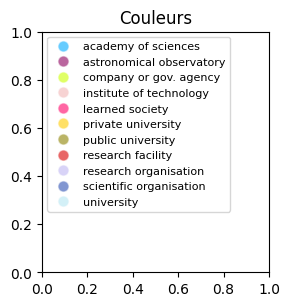

In [183]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [184]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.6348870654250937 0.7666666666666666


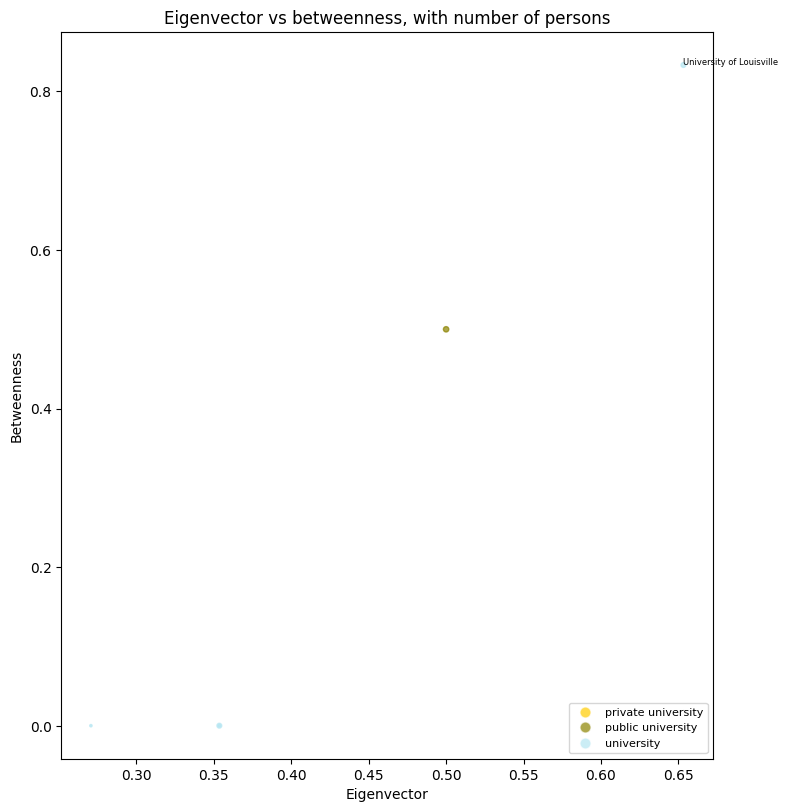

Spearman's rank correlation: 0.917662935482247


In [185]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [186]:
list(nodes_df.columns)

['id', 'label', 'mainType', 'membersNumber', 'eigenvector', 'betweenness']

In [187]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                          label           mainType membersNumber
4      University of Louisville         university             4
3  University of South Carolina  public university             5
0           National University         university             1
1        University of Kentucky         university             4
2           Converse University         university             1

-----
Eigenvector
                          label           mainType membersNumber
4      University of Louisville         university             4
3  University of South Carolina  public university             5
0           National University         university             1
1        University of Kentucky         university             4
2           Converse University         university             1


#### Plot graph

In [188]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1950-1974.svg


In [189]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


C:\Users\tangu\AppData\Local\Temp\ipykernel_23576\452596361.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


### Communitites

In [190]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


2
[3, 2]
[({'http://www.wikidata.org/entity/Q1024426', 'http://www.wikidata.org/entity/Q5166453'}, 2)]


In [196]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))




Community 0 
Betweenness
                      label    mainType membersNumber
4  University of Louisville  university             4
0       National University  university             1
1    University of Kentucky  university             4

-----
Eigenvector
                      label    mainType membersNumber
4  University of Louisville  university             4
0       National University  university             1
1    University of Kentucky  university             4


Community 1 
Betweenness
                          label           mainType membersNumber
3  University of South Carolina  public university             5
2           Converse University         university             1

-----
Eigenvector
                          label           mainType membersNumber
3  University of South Carolina  public university             5
2           Converse University         university             1


Community 2 
Betweenness


IndexError: list index out of range

#### Plot communitites graph

In [197]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

images/organisations/edu_edu_communities_1950-1974.svg


In [198]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


C:\Users\tangu\AppData\Local\Temp\ipykernel_23576\2935194816.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


## Create general function

In [199]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [200]:
print(df_mainTypes.mainType.to_list())

['university', 'educational institution', 'public university', 'not classified organisation', 'private university', 'learned society', 'company or gov. agency', 'academy of sciences', 'scientific organisation', 'research organisation', 'institute of technology', 'astronomical observatory', 'research facility']


In [201]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

C:\Users\tangu\AppData\Local\Temp\ipykernel_23576\2790567326.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  txt = str(df_g.groupby('periods').size())


1800-1824
Too small graph to be analyzed!
1825-1849
Too small graph to be analyzed!
1850-1874
'charmap' codec can't encode character '\u0142' in position 574: character maps to <undefined>
1875-1899
1900-1924
Too small graph to be analyzed!
1925-1949
1950-1974
Too small graph to be analyzed!
1975-1999
Too small graph to be analyzed!


In [202]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1800-1824
Too small graph to be analyzed!
1825-1849
Too small graph to be analyzed!
1850-1874
Too small graph to be analyzed!
1875-1899
Too small graph to be analyzed!
1900-1924
Too small graph to be analyzed!
1925-1949
Too small graph to be analyzed!
1950-1974
Too small graph to be analyzed!
1975-1999
list index out of range
Too small graph to be analyzed!


C:\Users\tangu\AppData\Local\Temp\ipykernel_23576\2790567326.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  txt = str(df_g.groupby('periods').size())


In [203]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1800-1824
Too small graph to be analyzed!
1825-1849
Too small graph to be analyzed!
1850-1874
Too small graph to be analyzed!
1875-1899
Too small graph to be analyzed!
1900-1924
Too small graph to be analyzed!
1925-1949
Too small graph to be analyzed!
1950-1974
Too small graph to be analyzed!
1975-1999
Too small graph to be analyzed!


C:\Users\tangu\AppData\Local\Temp\ipykernel_23576\2790567326.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  txt = str(df_g.groupby('periods').size())
